In [1]:
#data loading
import os
import datasets
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score


scratch_path = '/scratch/zdz/OLIVES_Dataset_biomarker'

os.makedirs(scratch_path, exist_ok=True)

ds = load_dataset("gOLIVES/OLIVES_Dataset", "biomarker_detection", cache_dir=scratch_path)

print(f"Dataset download to: {scratch_path}")
print(f"train set have {len(ds['train'])} samples")
print(f"test set have {len(ds['test'])} samples")

# transfer dataset to torch
ds = ds.with_format("torch")

# remove Null samples
def is_valid_sample(data_point):
    return (
        data_point['Image'] is not None
        and not torch.isnan(torch.tensor(data_point['BCVA']))
        and not torch.isnan(torch.tensor(data_point['CST']))
        and not any(torch.isnan(torch.tensor(data_point[key])) for key in ['B1'])
    )

ds = ds.filter(is_valid_sample)
print(f"Filtered dataset contains {len(ds['train'])} samples.")
print(f"Filtered dataset contains {len(ds['test'])} samples.")


Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset download to: /scratch/zdz/OLIVES_Dataset_biomarker
train set have 78822 samples
test set have 3871 samples
Filtered dataset contains 17444 samples.
Filtered dataset contains 3871 samples.


In [2]:
#Functions define

# Dataset definition
class OlivesDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        # Load the image
        img = self.data[idx]['Image']
        img = img.float()  # Convert to float type
        
        if len(img.shape) == 3 and img.shape[0] == 3:  # If the image has three channels
            img = img.mean(dim=0, keepdim=True)  # Convert to single channel
        elif len(img.shape) == 2:  # If the image is already single channel
            img = img.unsqueeze(0)  # Add a channel dimension

        # Apply preprocessing
        if self.transform:
            img = self.transform(img)

        # Load clinical features
        clinical = torch.tensor([
            self.data[idx]['BCVA'],
            self.data[idx]['CST']
        ], dtype=torch.float32)

        # Load labels
        label = torch.tensor([
            self.data[idx]['B1'],
            self.data[idx]['B3'],
            self.data[idx]['B4'],
            self.data[idx]['B5']
        ], dtype=torch.float32)

        return {'Image': img, 'Clinical': clinical, 'Label': label}

    def __len__(self):
        return len(self.data)



class MultiModalModel(nn.Module):
    def __init__(self):
        super(MultiModalModel, self).__init__()
        # Image feature extraction
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Single channel input
        self.image_model.fc = nn.Identity()  # Remove the final fully connected layer of ResNet
        image_feature_dim = 512  # Output dimension of the last ResNet18 layer

        # Clinical feature processing
        clinical_feature_dim = 16
        self.clinical_fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, clinical_feature_dim)
        )

        # Feature fusion and prediction
        self.fusion_fc = nn.Sequential(
            nn.Linear(image_feature_dim + clinical_feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output is 4 target labels
        )

    def forward(self, images, clinical_features):
        image_features = self.image_model(images)
        clinical_features = self.clinical_fc(clinical_features)
        combined_features = torch.cat((image_features, clinical_features), dim=1)
        outputs = self.fusion_fc(combined_features)
        return outputs


# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            images = batch['Image'].to(device)  # Image data
            clinical = batch['Clinical'].to(device)  # Clinical features
            labels = batch['Label'].to(device)  # Labels

            optimizer.zero_grad()
            outputs = model(images, clinical)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            total_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
        

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultiModalModel().to(device)

def evaluate_model_and_plot_roc(model, data_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch['Image'].to(device)
            clinical = batch['Clinical'].to(device)
            labels = batch['Label'].to(device)

            # Model predictions
            outputs = model(images, clinical)
            probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert to probabilities

            # Apply threshold to convert probabilities to binary labels
            predictions = (probabilities > threshold).astype(int)

            # Collect true labels, predictions, and probabilities
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions)
            all_probabilities.append(probabilities)

    # Convert to NumPy arrays
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    all_probabilities = np.vstack(all_probabilities)

    # 1. Calculate F1 Score
    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    per_biomarker_f1 = []
    for i in range(all_labels.shape[1]):
        f1 = f1_score(all_labels[:, i], all_predictions[:, i], average='binary')
        per_biomarker_f1.append(f1)

    # Print F1 Scores
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    for i, f1 in enumerate(per_biomarker_f1):
        print(f"F1 Score (Biomarker {i + 1}): {f1:.4f}")

    # 2. Calculate accuracy
    per_biomarker_accuracy = []
    for i in range(all_labels.shape[1]):
        accuracy = accuracy_score(all_labels[:, i], all_predictions[:, i])
        per_biomarker_accuracy.append(accuracy)

    # Print accuracies
    for i, acc in enumerate(per_biomarker_accuracy):
        print(f"Accuracy (Biomarker {i + 1}): {acc:.4f}")

    # 3. Plot ROC curves
    plt.figure(figsize=(10, 8))
    auc_scores = []
    for i in range(all_labels.shape[1]):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'Biomarker {i + 1} (AUC = {roc_auc:.2f})')

    # Add diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Add legend and labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Biomarkers')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    # Return evaluation results
    results = {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "per_biomarker_f1": per_biomarker_f1,
        "per_biomarker_accuracy": per_biomarker_accuracy,
        "auc_scores": auc_scores
    }
    return results

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Create DataLoader
train_dataset = OlivesDataset(ds['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = OlivesDataset(ds['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# ResNet18 training

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train the model
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10)

# Save model weights
torch.save(model.state_dict(), "resnet18_10epoch.pth")
print("Model weights saved to resnet18_10epoch.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/1, Loss: 0.3100
Model weights saved to resnet18_10epoch.pth


F1 Score (Micro): 0.6519
F1 Score (Macro): 0.6069
F1 Score (Biomarker 1): 0.6032
F1 Score (Biomarker 2): 0.7504
F1 Score (Biomarker 3): 0.5159
F1 Score (Biomarker 4): 0.5581
Accuracy (Biomarker 1): 0.7158
Accuracy (Biomarker 2): 0.7192
Accuracy (Biomarker 3): 0.7595
Accuracy (Biomarker 4): 0.9607


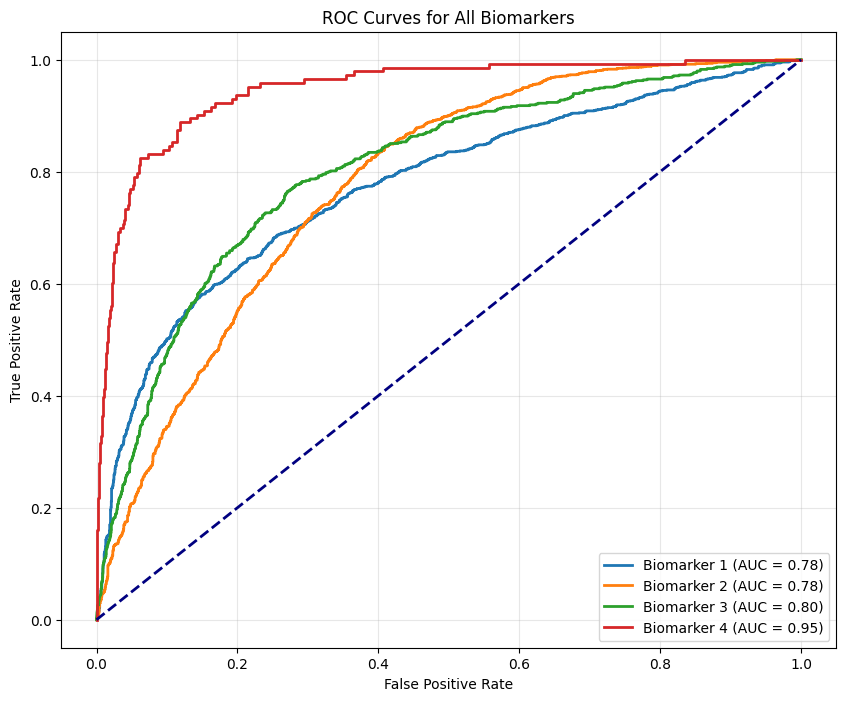

In [12]:
# Evaluation + output F1, accuracy, and ROC curves

model.load_state_dict(torch.load("resnet18_10epoch.pth"))
model.eval()

# Call the integrated evaluation function
evaluation_results = evaluate_model_and_plot_roc(model, test_loader)